In [1]:

import numpy as np
import matplotlib.pyplot as plt
import fixedpoint

import os
from scipy.io import wavfile
from IPython.display import Audio

PLOT = True

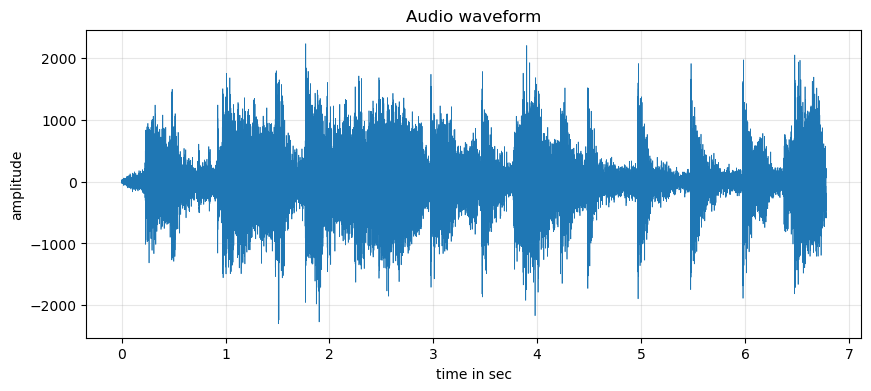

In [3]:
#input audio sample for DSP

tracks_location = "C:/Users/penel/MTRX_3700/Assignment 2"
expected_bpm = 120

input_audio_file = os.path.join(tracks_location, f"{expected_bpm}bpm_music.wav")
Audio(input_audio_file)

fs, signal = wavfile.read(input_audio_file)
signal = signal.astype(np.int64)
signal_length = len(signal) #number of samples in the signal

t = np.linspace(0, signal_length/fs, signal_length)

plt.figure(figsize=(10,4))
plt.plot(t, signal, linewidth=0.5)
plt.xlabel("time in sec")
plt.ylabel("amplitude")
plt.title("Audio waveform")
plt.grid(True, alpha=0.3)
plt.show()

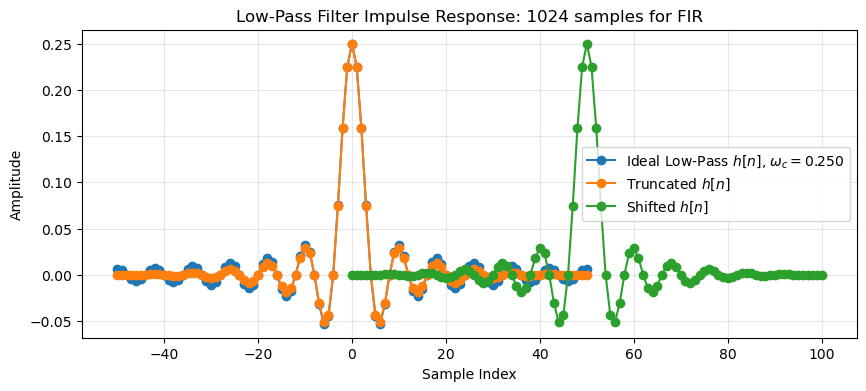

In [5]:
#Decimation and Low Pass Filter

#impulse Response that will be applied to audio sample
N = 101; #frame size of 1024 samples
cutoff_freq = fs / 8

omega_c = 2 * cutoff_freq / fs #normalised - Nyquist = fs/2
n = np.arange(N) - (N-1)/2
impulse_response = omega_c * np.sinc(omega_c * n)

plt.figure(figsize=(10,4))
plt.plot(n, impulse_response, "-o")

#truncate impulse with hanning window + shift to be n >= 0
impulse_response = impulse_response * np.hanning(N)
plt.plot(n, impulse_response, "o-")

n = np.arange(0, N)

#plot
plt.plot(n, impulse_response, "-o")
plt.title("Low-Pass Filter Impulse Response: 1024 samples for FIR")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend([f"Ideal Low-Pass $h[n]$, $\\omega_c={omega_c:.3f}$", "Truncated $h[n]$", "Shifted $h[n]$"])
plt.grid(True, alpha=0.3)


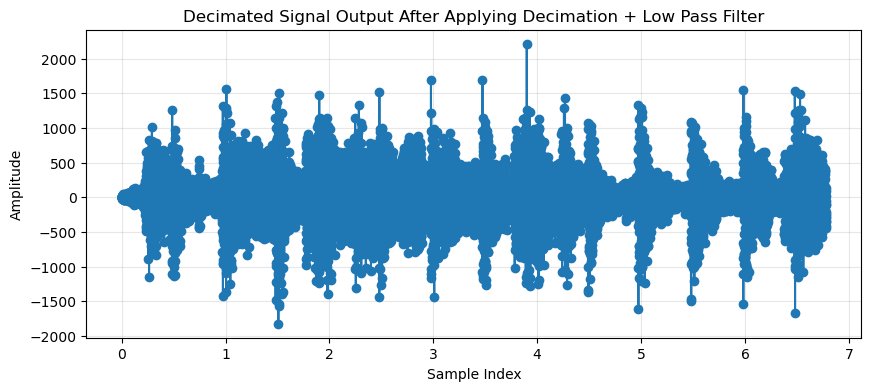

In [7]:
#apply low pass filter
filtered_signal = np.convolve(signal, impulse_response, mode="same")

#decimate
decimation_factor = 4
fs_decimated = fs / decimation_factor #new sampling frequency
decimated_signal = filtered_signal[::decimation_factor]

#plotting
t_decimated = np.linspace(0, len(decimated_signal)/fs_decimated, len(decimated_signal))

plt.figure(figsize=(10,4))
plt.plot(t_decimated, decimated_signal, "-o")
plt.title("Decimated Signal Output After Applying Decimation + Low Pass Filter")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True, alpha = 0.3)

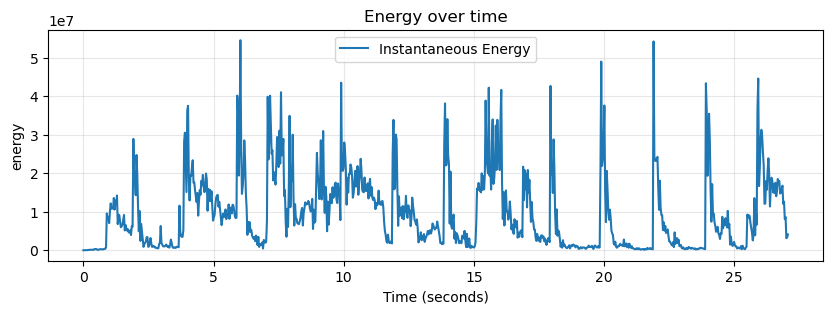

In [13]:
#divide singal into windows
sample_period = 1 / fs_decimated
sample_freq = fs_decimated

threshold = 2
refrac_timer = 150

window_duration = 0.03 #30ms per  window
window_length = int(sample_freq * window_duration)
refrac_cycles = sample_freq * refrac_timer

#calculate number of windows
num_windows = np.round(signal_length/window_length).astype(int)
energy = np.zeros(num_windows - 1)

#energy for each window
for i in range(num_windows - 1):
    window_start = i * window_length
    window_end = (i + 1) * window_length
    window_samples = signal[window_start:window_end]

    energy[i] = np.sum(window_samples ** 2)

#plotting energy
energy_time = np.arange(len(energy)) * window_duration
plt.figure(figsize=(10,3))
plt.plot(energy_time, energy, label='Instantaneous Energy')
plt.xlabel("Time (seconds)")
plt.ylabel("energy")
plt.title("Energy over time")
plt.legend()
plt.grid(True, alpha=0.3)

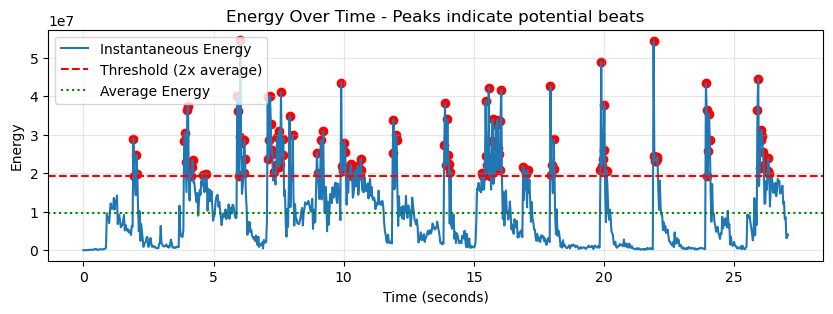

In [19]:
#thresholding

average_energy = np.mean(energy)
threshold = 2 * average_energy

# Plot energy over time
plt.figure(figsize=(10, 3))
plt.plot(energy_time, energy, label='Instantaneous Energy')
plt.axhline(threshold, color='r', linestyle='--', label=f'Threshold (2x average)')
plt.axhline(average_energy, color='g', linestyle=':', label=f'Average Energy')
plt.xlabel("Time (seconds)")
plt.ylabel("Energy")
plt.title("Energy Over Time - Peaks indicate potential beats")
plt.legend()
plt.grid(True, alpha=0.3)

beat_times = energy_time[energy > threshold]
plt.scatter(beat_times, energy[energy > threshold], color='red')